# K Nearest Neighbours Classifier
In this notebook, I will be creating a K Nearest Neighbours classifier for the loan data. First, We will start with a baseline model and investigate the many ways this might be improved.

In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding

In [5]:
pd.set_option('display.max_columns', None)

loan_data = pd.read_csv("my_full_data.csv")
display(loan_data)

,Unnamed: 0,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,open_acc,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tax_liens
0,0,68387134,2500.0,0,17.27,89.47,3,1,1,50000.0,2,1,9,9,17.60,7.0,22.0,1,669.0,665.0,0,0.0
1,1,66615254,7200.0,0,17.27,257.67,3,9,4,20000.0,2,0,2,18,13.21,8.0,17.0,1,549.0,545.0,0,0.0
2,2,68376899,16000.0,0,10.78,522.16,1,5,5,63000.0,0,0,2,33,35.19,12.0,22.0,1,594.0,590.0,0,0.0
3,3,68366850,16000.0,0,5.32,481.84,0,8,1,96000.0,0,1,2,22,14.45,23.0,38.0,1,744.0,740.0,0,0.0
4,4,67195202,13000.0,1,16.59,320.23,3,10,5,40000.0,2,0,2,11,16.74,6.0,17.0,1,569.0,565.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26113,26113,90441274,12000.0,0,13.99,410.08,2,0,5,47000.0,1,1,1,25,31.79,13.0,28.0,0,754.0,750.0,0,0.0
26114,26114,90404436,25000.0,1,25.69,743.94,5,6,1,70000.0,2,0,9,5,15.10,9.0,19.0,0,499.0,0.0,0,0.0
26115,26115,90393111,16000.0,0,12.79,537.49,2,1,4,48000.0,0,1,2,4,33.60,11.0,17.0,0,699.0,695.0,0,0.0
26116,26116,90304259,35000.0,1,15.59,843.53,2,1,1,180000.0,2,1,2,9,13.09,17.0,31.0,0,714.0,710.0,0,0.0


## Baseline Model

Here we create a baseline KNN model with $K = \frac{1}{2} \sqrt{N}$ where $N =$ sample size. From a review of some literature, this seems to be a initial value. This is a rule of thumb so we will look to optimise this when we carry out hyperparameter optimisation. Furthermore, we plot both a ROC and precision-recall curve. We dive into which is more appropriate and other performance metrics later on.

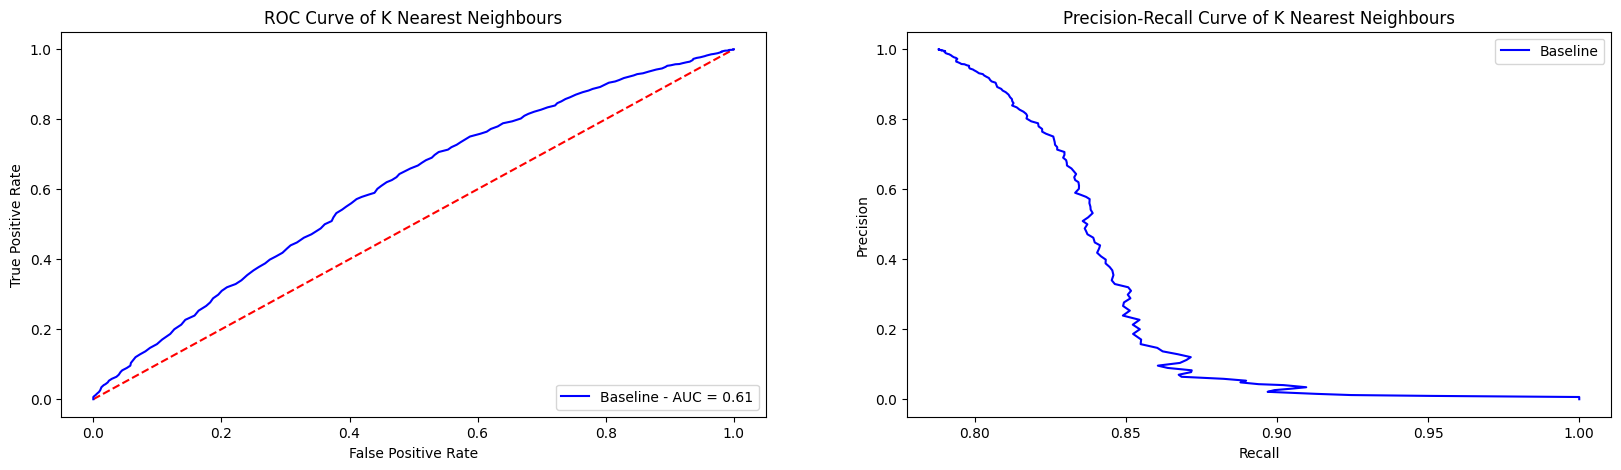

In [6]:
X = loan_data.drop(['loan_status', 'id'], axis=1)
y = loan_data['loan_status']

#Create training and test datasets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.20, random_state = 5)
KNN = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.size)))
KNN.fit(X_train, y_train)
y_pred_baseline = KNN.predict(X_test)
y_scores=KNN.predict_proba(X_test)
fpr,tpr,threshold =roc_curve(y_test, y_scores[:,1])
fpr_precision_recall,tpr_precision_recall,threshold_precision_recall = precision_recall_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

fig, (ax, ax0) = plt.subplots(1, 2, figsize=(20, 5))

ax.plot([0, 1], [0, 1],'r--')
ax.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)

ax0.plot(fpr_precision_recall, tpr_precision_recall,'b', label = 'Baseline')

ax.set_title("ROC Curve of K Nearest Neighbours")
ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax.legend(loc = 'lower right')

ax0.set_title("Precision-Recall Curve of K Nearest Neighbours")
ax0.set(xlabel="Recall", ylabel="Precision")
ax0.legend(loc = 'upper right')

plt.show()

In terms of AUC score, this ROC curve shows that our baseline model is just a bit better than good as guessing randomly whether or nor a loan is approved or not.

## Feature Scaling

An initial avenue of exploration might be to scale the dataset. The reasoning behind this is that if some features are too large, they might have an outsized influence on the the distance calculation. First, we look to see where the distribution of some columns in the the loan dataset are a lot larger than others. This might signfy that scaling is prudent.  


In [7]:
X.describe()

,Unnamed: 0,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,open_acc,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tax_liens
count,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,2.611800e+04,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000
mean,13058.500000,14713.151849,0.251359,13.294063,446.066954,1.756222,3.618616,2.913814,7.806945e+04,0.987442,2.688376,22.411019,18.179145,11.669845,25.057202,0.596294,676.627154,660.080596,0.020675,0.050425
std,7539.761502,8780.390798,0.433803,4.798467,263.632169,1.296153,3.181869,1.920452,6.676169e+04,0.774144,2.380318,14.756850,9.702454,5.507822,12.044223,0.490649,80.638253,130.432796,0.142298,0.354201
min,0.000000,1000.000000,0.000000,5.310000,28.690000,0.000000,0.000000,0.000000,3.500000e+03,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6529.250000,8000.000000,0.000000,9.750000,253.880000,1.000000,1.000000,1.000000,4.800000e+04,0.000000,2.000000,9.000000,11.690000,8.000000,16.000000,0.000000,629.000000,625.000000,0.000000,0.000000
50%,13058.500000,12800.000000,0.000000,12.790000,385.470000,2.000000,2.000000,4.000000,6.500000e+04,1.000000,2.000000,21.000000,17.560000,11.000000,23.000000,1.000000,694.000000,690.000000,0.000000,0.000000
75%,19587.750000,20000.000000,1.000000,16.020000,593.482500,3.000000,6.000000,5.000000,9.300000e+04,2.000000,2.000000,34.000000,23.860000,14.000000,32.000000,1.000000,734.000000,730.000000,0.000000,0.000000
max,26117.000000,40000.000000,1.000000,30.990000,1566.800000,6.000000,10.000000,5.000000,5.604824e+06,2.000000,13.000000,49.000000,446.050000,63.000000,110.000000,1.000000,850.000000,845.000000,1.000000,12.000000


We can see that some columns are orders of magnitudes larger than others and so we proceed with scaling and compare the performance. We have the following three types of scaling that we can to carry out:
- Standard scaling: Rescales the dataset such that it is approximately standard normally distributed.
\begin{align*}
    x_{i}^{'} =  \frac{x_{i} - \overline{x}}{\sigma}
\end{align*}
- Robust scaling: This is a scaling method that is works well with data that has a lot of outliers as the scaling is unaffected by outliers.
\begin{align*}
    x_{i}^{'} =  \frac{x_{i} - Q_{1}}{Q_{3} - Q_{1}}
\end{align*}
where $Q_{1}$ and $Q_{3}$ are the first and third quartile respectively.
- Min-max scaling: This scales all the data down to the interval $[0, 1]$
\begin{align*}
    x_{i}^{'} =  \frac{x_{i} - \min_{i}{x}}{\max_{i}{x} - \min_{i}{x}}
\end{align*}

There is already a built-in function to perform standardised scaling but it was harder to find some for the other types of feature scaling so they are written below. 

In [8]:
def min_max_scaling(df, column_name):
    min_value = df[column_name].min()
    max_value = df[column_name].max()
    df[column_name] = (df[column_name] - min_value) / (max_value - min_value)

def robust_scaling(df, column_name):
    median_value = df[column_name].median()
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    df[column_name] = (df[column_name] - median_value) / iqr

In [9]:
X_min_max = X.copy()
X_robust_scaling = X.copy()

for column in X:
    X[column] = stats.zscore(X[column])
    min_max_scaling(X_min_max, column)
    robust_scaling(X_robust_scaling, column)

In [10]:
print(X.describe())
print(X_min_max.describe())
print(X_robust_scaling.describe())

         Unnamed: 0     loan_amnt          term      int_rate   installment  \
count  2.611800e+04  2.611800e+04  2.611800e+04  2.611800e+04  2.611800e+04   
mean  -6.964505e-17 -8.596811e-17 -5.930711e-17 -2.916386e-16 -2.611689e-17   
std    1.000019e+00  1.000019e+00  1.000019e+00  1.000019e+00  1.000019e+00   
min   -1.731984e+00 -1.561823e+00 -5.794429e-01 -1.663910e+00 -1.583209e+00   
25%   -8.659922e-01 -7.645765e-01 -5.794429e-01 -7.385966e-01 -7.290106e-01   
50%    0.000000e+00 -2.178933e-01 -5.794429e-01 -1.050488e-01 -2.298586e-01   
75%    8.659922e-01  6.021314e-01  1.725796e+00  5.680958e-01  5.591820e-01   
max    1.731984e+00  2.879978e+00  1.725796e+00  3.687902e+00  4.251205e+00   

              grade    emp_length  home_ownership    annual_inc  \
count  2.611800e+04  2.611800e+04    2.611800e+04  2.611800e+04   
mean   2.502869e-17  3.509458e-17   -4.488841e-17  3.373432e-17   
std    1.000019e+00  1.000019e+00    1.000019e+00  1.000019e+00   
min   -1.354976e+00 

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - valu

We see that while we are able to scale the dataset appropropriately using z-scores and min-max scaling, this is not the case for robust scaling. This is because some columns are mostly filled with `Nan` values when we call the `describe` method. This might be because the hot-one encoding of some catergorical data with only a few categories means that the distributions of some columns are heavily skewed towards $0$.

Due to this, we only consider `X` and `X_min_max`.

Below we look at some performance metrics for our dataset. Namely, we plot ROC curves for our baseline model with our different feature scaling applied and calculate the AUC metrics. We also plot some confusion matrices. As we have many performance metrics that we can possibly look at, we discuss their merits for this dataset and project.

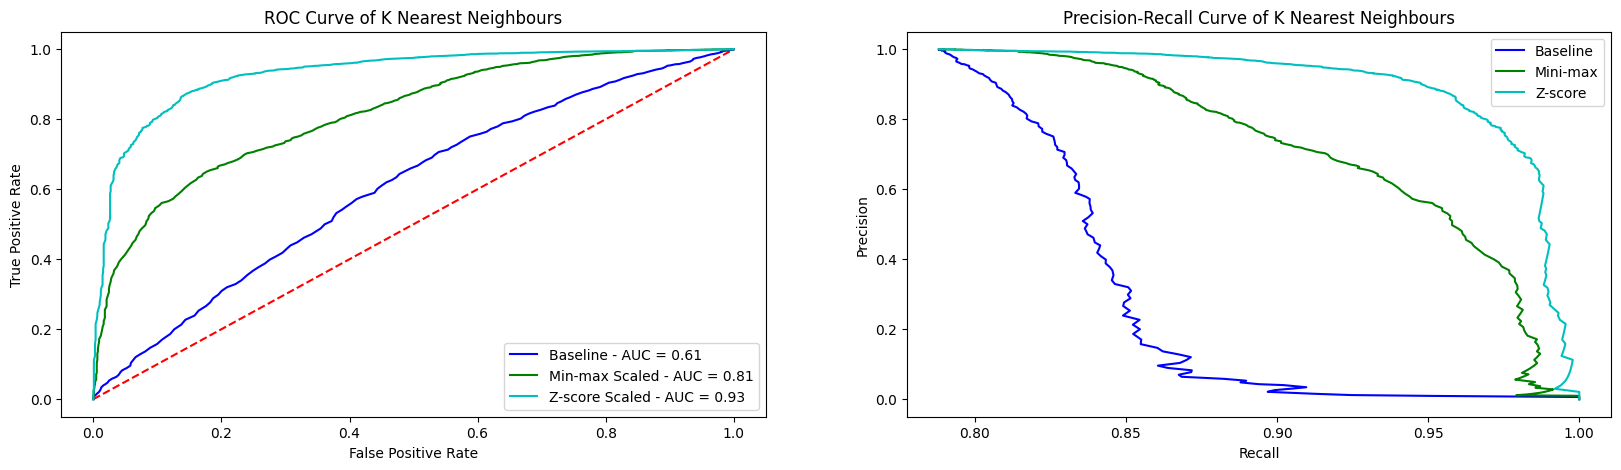

In [11]:
# Min-max scaling
X_train0, X_test0, y_train0, y_test0 = sklearn.model_selection.train_test_split(X_min_max, y, test_size = 0.20, random_state = 5)
KNN0 = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.size)))
KNN0.fit(X_train0, y_train0)
y_pred_baseline0 = KNN0.predict(X_test0)
y_scores0 = KNN0.predict_proba(X_test0)
fpr0, tpr0, threshold0 = roc_curve(y_test0, y_scores0[:,1])
fpr0_precision_recall, tpr0_precision_recall, threshold0_precision_recall = precision_recall_curve(y_test0, y_scores0[:,1])
roc_auc0 = auc(fpr0, tpr0)

# Standard scaling
X_train1, X_test1, y_train1, y_test1 = sklearn.model_selection.train_test_split(X, y, test_size = 0.20, random_state = 5)
KNN1 = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.size)))
KNN1.fit(X_train1, y_train1)
y_pred_baseline1 = KNN1.predict(X_test1)
y_scores1 = KNN1.predict_proba(X_test1)
fpr1, tpr1, threshold1 = roc_curve(y_test1, y_scores1[:,1])
fpr1_precision_recall, tpr1_precision_recall, threshold1_precision_recall = precision_recall_curve(y_test1, y_scores1[:,1])
roc_auc1 = auc(fpr1, tpr1)


fig, (ax, ax0) = plt.subplots(1, 2, figsize=(20, 5))

ax.plot([0, 1], [0, 1],'r--')
ax.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)
ax.plot(fpr0, tpr0, 'g', label = 'Min-max Scaled - AUC = %0.2f' % roc_auc0)
ax.plot(fpr1, tpr1, 'c', label = 'Z-score Scaled - AUC = %0.2f' % roc_auc1)

ax0.plot(fpr_precision_recall, tpr_precision_recall, 'b', label = 'Baseline')
ax0.plot(fpr0_precision_recall, tpr0_precision_recall, 'g', label = 'Mini-max')
ax0.plot(fpr1_precision_recall, tpr1_precision_recall, 'c', label = 'Z-score')


ax.set_title("ROC Curve of K Nearest Neighbours")
ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax.legend(loc = 'lower right')

ax0.set_title("Precision-Recall Curve of K Nearest Neighbours")
ax0.set(xlabel="Recall", ylabel="Precision")
ax0.legend(loc = 'upper right')

plt.show()

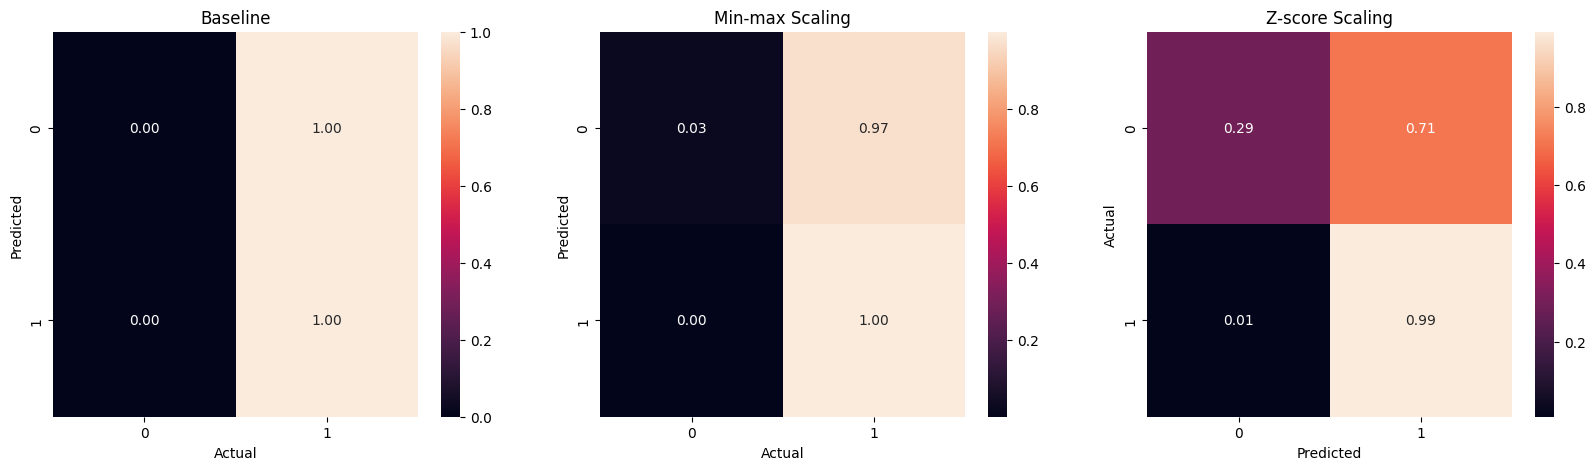

In [12]:
cm = confusion_matrix(y_test, y_pred_baseline)
cm0 = confusion_matrix(y_test0, y_pred_baseline0)
cm1 = confusion_matrix(y_test1, y_pred_baseline1)

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmn0 = cm0.astype('float') / cm0.sum(axis=1)[:, np.newaxis]
cmn1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
fig, (ax, ax0, ax1) = plt.subplots(1, 3, figsize=(20, 5))
sns.heatmap(cmn, annot=True, fmt='.2f', ax=ax)
ax.set_title("Baseline")
ax.set(xlabel="Actual", ylabel="Predicted")
sns.heatmap(cmn0, annot=True, fmt='.2f', ax=ax0)
ax0.set_title('Min-max Scaling')
ax0.set(xlabel="Actual", ylabel="Predicted")
sns.heatmap(cmn1, annot=True, fmt='.2f', ax=ax1)
ax1.set_title('Z-score Scaling')
ax1.set(xlabel="Actual", ylabel="Predicted")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

We can see that both types of feature scaling yield better results than our baseline model which did not have a scaled dataset. We can see these with both the graphs and also our heatmaps. We note although the min-max scaling does provide some improvement, it is not as good as the standardisation. One reason this might be is because standardisation allows for outliers to be quite from each other where as the min-max scaling reduces everything to the unit interval. This means that we somewhat reduce the full depth of the data using min-max scaling whereas standardisation keeps this but ensures that the columns are comparable to each other.

Interestingly, for both types of scaling, we have the same False Negative and True Positive rates. It seems that it is because it is quite easy for our model to tell if we have a distinctly positive predicition but not the other way around. This might be as we have a large number of positive values in response variable. Below, we see that ~$78$% of the entries in the response variable are positive predicitons. This might mean that we need to change how we split our data or find another way to address this class imbalance.

In [13]:
np.sum(y)/len(y)

np.float64(0.7870434183321847)

## Curse of Dimensionality

A commonly-faced problem with K Nearest Neighbours models is the curse of dimensionality. In essence, this means that as the number of features/dimensions increase, the volume of the feature space grows exponentially. This leads to data becoming sparser in higher dimensions. This affects the performance of KNN as higher dimensions means that distances become more uniform and so it is harder to determine where a new point belongs as the distances to its neighbours become similar.

We can carry out the following two dimensionality reduction techniques to try and lessen the effects of the curse of dimensionality:
* PCA (Principal Component Analysis) - A dimension reduction technique that projects the data onto a different coordinate space while maximising variance 
* LDA (Linear Discriminant Analysis) - A dimension reduction technique with the goal of maximising the distance between classes and minimsing the distance inside each class all while reducing dimensions

Furthermore, we have some nonlinear dimension reduction technique. This is sometimes called manifold learning: 
* Isomap (Isometric Mapping)
* LLE (Locally Linear Embedding)

These methods all have their pros and cons but we will try them out to see how they compare against each other.

### PCA

We perform PCA and do a search to find the best argument for the `n_components` argument.

In [19]:
max_roc_auc2 = [0, 0]
for i in range(1, 20):
    pca = PCA(n_components = i)
    X_pca = pca.fit_transform(X)

    X_train2, X_test2, y_train2, y_test2 = sklearn.model_selection.train_test_split(X_pca, y, test_size = 0.20, random_state = 5)
    KNN2 = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.size)))
    KNN2.fit(X_train2, y_train2)
    y_pred_baseline2 = KNN2.predict(X_test2)
    y_scores2 = KNN2.predict_proba(X_test2)
    fpr2, tpr2, threshold2 = roc_curve(y_test2, y_scores2[:,1])
    roc_auc2 = auc(fpr2, tpr2)
    if roc_auc2 > max_roc_auc2[0]:
        max_roc_auc2 = (roc_auc2, i)

pca = PCA(n_components = max_roc_auc2[1])
X_pca = pca.fit_transform(X)

X_train2, X_test2, y_train2, y_test2 = sklearn.model_selection.train_test_split(X_pca, y, test_size = 0.20, random_state = 5)
KNN2 = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.size)))
KNN2.fit(X_train2, y_train2)
y_pred_baseline2 = KNN2.predict(X_test2)
y_scores2 = KNN2.predict_proba(X_test2)
fpr2, tpr2, threshold2 = roc_curve(y_test2, y_scores2[:,1])
fpr2_precision_recall, tpr2_precision_recall, threshold2_precision_recall = precision_recall_curve(y_test2, y_scores2[:,1])
roc_auc2 = auc(fpr2, tpr2)

### LDA

In [20]:
lda = LinearDiscriminantAnalysis() 
lda = lda.fit(X, y)
X_lda = lda.transform(X)

X_train3, X_test3, y_train3, y_test3 = sklearn.model_selection.train_test_split(X_lda, y, test_size = 0.20, random_state = 5)
KNN3 = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.size)))
KNN3.fit(X_train3, y_train3)
y_pred_baseline3 = KNN3.predict(X_test3)
y_scores3 = KNN3.predict_proba(X_test3)
fpr3, tpr3, threshold3 = roc_curve(y_test3, y_scores3[:,1])
fpr3_precision_recall, tpr3_precision_recall, threshold3_precision_recall = precision_recall_curve(y_test3, y_scores3[:,1])
roc_auc3 = auc(fpr3, tpr3)

### Isomap

The isomap dimension reduction technique takes a while to run so we only run it for one parameter choice of `n_components`.

In [22]:
embedding = Isomap()
X_isomap = embedding.fit_transform(X)

X_train4, X_test4, y_train4, y_test4 = sklearn.model_selection.train_test_split(X_isomap, y, test_size = 0.20, random_state = 5)
KNN4 = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.size)))
KNN4.fit(X_train4, y_train4)
y_pred_baseline4 = KNN4.predict(X_test4)
y_scores4 = KNN4.predict_proba(X_test4)
fpr4, tpr4, threshold4 = roc_curve(y_test4, y_scores4[:,1])
fpr4_precision_recall, tpr4_precision_recall, threshold4_precision_recall = precision_recall_curve(y_test4, y_scores4[:,1])
roc_auc4 = auc(fpr4, tpr4)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


### LLE

In [23]:
embedding = LocallyLinearEmbedding()
X_lle = embedding.fit_transform(X)

X_train5, X_test5, y_train5, y_test5 = sklearn.model_selection.train_test_split(X_lle, y, test_size = 0.20, random_state = 5)
KNN5 = KNeighborsClassifier(n_neighbors=int(np.sqrt(X.size)))
KNN5.fit(X_train5, y_train5)
y_pred_baseline5 = KNN5.predict(X_test5)
y_scores5 = KNN5.predict_proba(X_test5)
fpr5, tpr5, threshold5 = roc_curve(y_test5, y_scores5[:,1])
fpr5_precision_recall, tpr5_precision_recall, threshold5_precision_recall = precision_recall_curve(y_test5, y_scores5[:,1])
roc_auc5 = auc(fpr5, tpr5)

Now, we plot ROC and precision-recall curves.

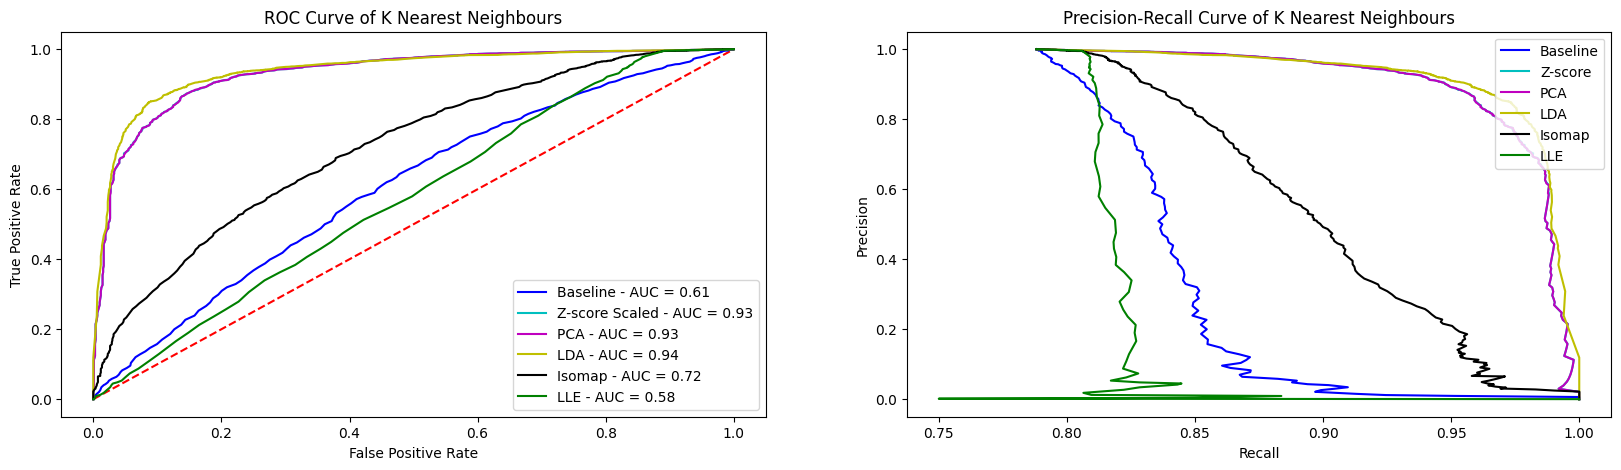

In [26]:
fig, (ax, ax0) = plt.subplots(1, 2, figsize=(20, 5))

ax.plot([0, 1], [0, 1],'r--')
ax.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)
ax.plot(fpr1, tpr1, 'c', label = 'Z-score Scaled - AUC = %0.2f' % roc_auc1)
ax.plot(fpr2, tpr2, 'm', label = 'PCA - AUC = %0.2f' % roc_auc2)
ax.plot(fpr3, tpr3, 'y', label = 'LDA - AUC = %0.2f' % roc_auc3)
ax.plot(fpr4, tpr4, 'k', label = 'Isomap - AUC = %0.2f' % roc_auc4)
ax.plot(fpr5, tpr5, 'g', label = 'LLE - AUC = %0.2f' % roc_auc5)

ax0.plot(fpr_precision_recall, tpr_precision_recall, 'b', label = 'Baseline')
ax0.plot(fpr1_precision_recall, tpr1_precision_recall, 'c', label = 'Z-score')
ax0.plot(fpr2_precision_recall, tpr2_precision_recall, 'm', label = 'PCA')
ax0.plot(fpr3_precision_recall, tpr3_precision_recall, 'y', label = 'LDA')
ax0.plot(fpr4_precision_recall, tpr4_precision_recall, 'k', label = 'Isomap')
ax0.plot(fpr5_precision_recall, tpr5_precision_recall, 'g', label = 'LLE')

ax.set_title("ROC Curve of K Nearest Neighbours")
ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax.legend(loc = 'lower right')

ax0.set_title("Precision-Recall Curve of K Nearest Neighbours")
ax0.set(xlabel="Recall", ylabel="Precision")
ax0.legend(loc = 'upper right')

plt.show()

While the AUC score of the LDA transformed dataset is slightly higher than the of the PCA transformed dataset, we see that the difference is a lot more distinct for the precision-recall curve. To further look into this, we show a classification report that displays some performance metrics. Also, looking at the ROC curves and the AUC metrics, it is clear that the nonlinear dimension reduction techniques did not work well for our purpose.

In [28]:
print(classification_report(y_test2, y_pred_baseline2))
print('Accuracy Score - KNN - PCA:', metrics.accuracy_score(y_test, y_pred_baseline2))

print(classification_report(y_test3, y_pred_baseline3))
print('Accuracy Score - KNN - LDA:', metrics.accuracy_score(y_test, y_pred_baseline3))

              precision    recall  f1-score   support

           0       0.90      0.29      0.44      1107
           1       0.84      0.99      0.91      4117

    accuracy                           0.84      5224
   macro avg       0.87      0.64      0.67      5224
weighted avg       0.85      0.84      0.81      5224

Accuracy Score - KNN - PCA: 0.8430321592649311
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1107
           1       0.94      0.93      0.94      4117

    accuracy                           0.90      5224
   macro avg       0.85      0.85      0.85      5224
weighted avg       0.90      0.90      0.90      5224

Accuracy Score - KNN - LDA: 0.8993108728943339


We see that across most metrics (11/13), the LDA transformed dataset performs better. 

## Grid Search

There are quite a few more parameters and hyperparameters that we can tweak to improve the performance of our model. These include 

In [31]:
grid_search_KNN = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid={'n_neighbors': (400, 750, 50),
                'leaf_size': (20,40,1),
                'p': (1,2),
                'weights': ('uniform', 'distance'),
                'metric': ('minkowski', 'chebyshev', 'cityblock', 'cosine', 'euclidean',
                        'l1', 'l2', 'manhattan', 'nan_euclidean'),
            },           
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5
)

grid_search_KNN.fit(X_lda, y)
print(grid_search_KNN.best_score_)
print(grid_search_KNN.best_params_)
print(grid_search_KNN.best_estimator_)

0.9360721441627955
{'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 750, 'p': 1, 'weights': 'uniform'}
KNeighborsClassifier(leaf_size=20, n_neighbors=750, p=1)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [52]:
X_train6, X_test6, y_train6, y_test6 = sklearn.model_selection.train_test_split(X_lda, y, test_size = 0.20, random_state = 5)
y_pred_baseline6 = grid_search_KNN.predict(X_test6)
y_scores6 = grid_search_KNN.predict_proba(X_test6)
fpr6, tpr6, threshold6 = roc_curve(y_test6, y_scores6[:,1])
fpr6_precision_recall, tpr6_precision_recall, threshold6_precision_recall = precision_recall_curve(y_test6, y_scores6[:,1])
roc_auc6 = auc(fpr6, tpr6)

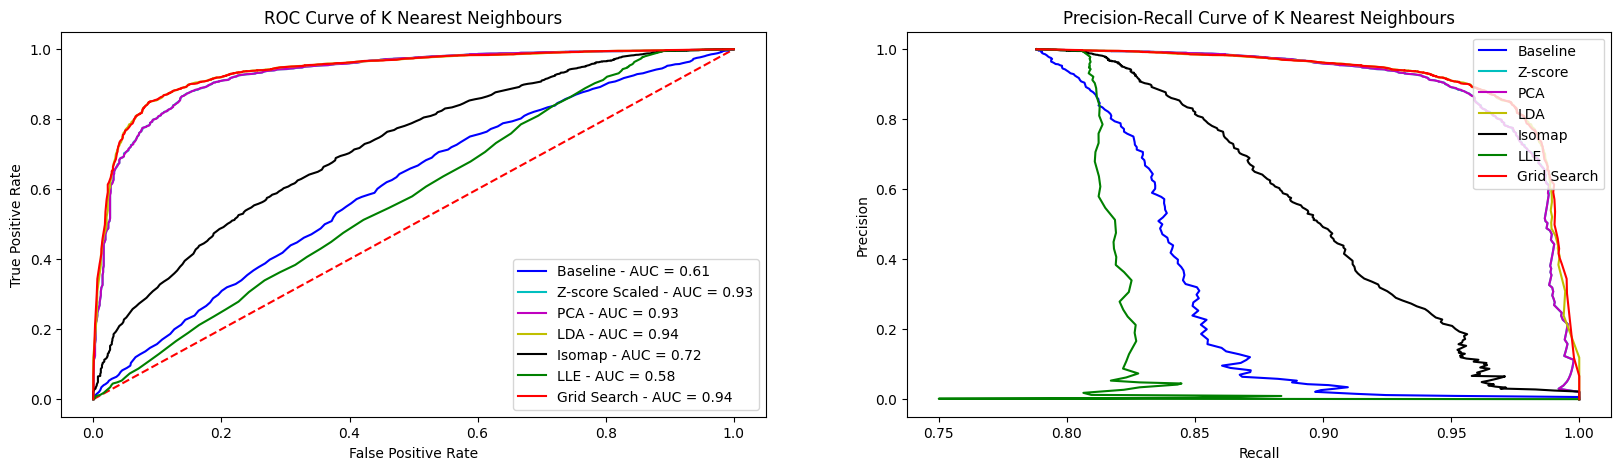

In [53]:
fig, (ax, ax0) = plt.subplots(1, 2, figsize=(20, 5))

ax.plot([0, 1], [0, 1],'r--')
ax.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)
ax.plot(fpr1, tpr1, 'c', label = 'Z-score Scaled - AUC = %0.2f' % roc_auc1)
ax.plot(fpr2, tpr2, 'm', label = 'PCA - AUC = %0.2f' % roc_auc2)
ax.plot(fpr3, tpr3, 'y', label = 'LDA - AUC = %0.2f' % roc_auc3)
ax.plot(fpr4, tpr4, 'k', label = 'Isomap - AUC = %0.2f' % roc_auc4)
ax.plot(fpr5, tpr5, 'g', label = 'LLE - AUC = %0.2f' % roc_auc5)
ax.plot(fpr6, tpr6, 'r', label = 'Grid Search - AUC = %0.2f' % roc_auc6)

ax0.plot(fpr_precision_recall, tpr_precision_recall, 'b', label = 'Baseline')
ax0.plot(fpr1_precision_recall, tpr1_precision_recall, 'c', label = 'Z-score')
ax0.plot(fpr2_precision_recall, tpr2_precision_recall, 'm', label = 'PCA')
ax0.plot(fpr3_precision_recall, tpr3_precision_recall, 'y', label = 'LDA')
ax0.plot(fpr4_precision_recall, tpr4_precision_recall, 'k', label = 'Isomap')
ax0.plot(fpr5_precision_recall, tpr5_precision_recall, 'g', label = 'LLE')
ax0.plot(fpr6_precision_recall, tpr6_precision_recall, 'r', label = 'Grid Search')

ax.set_title("ROC Curve of K Nearest Neighbours")
ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax.legend(loc = 'lower right')

ax0.set_title("Precision-Recall Curve of K Nearest Neighbours")
ax0.set(xlabel="Recall", ylabel="Precision")
ax0.legend(loc = 'upper right')

plt.show()

As it is rather difficult to see the differences in our graphs, we zoom in on them.

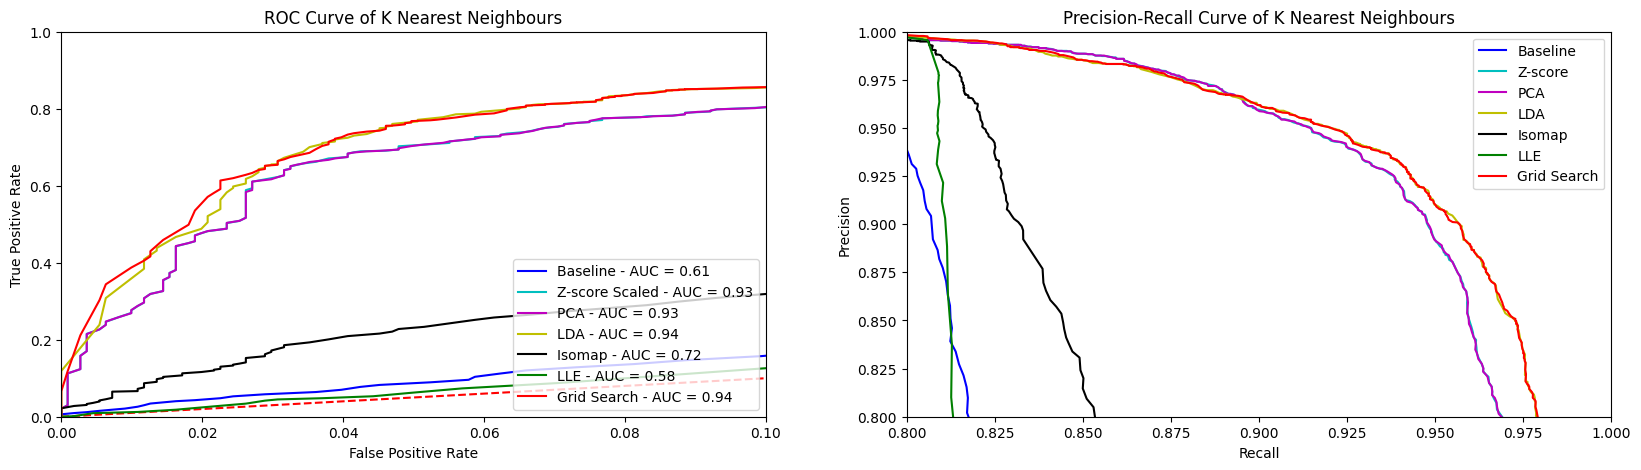

In [54]:
fig, (ax, ax0) = plt.subplots(1, 2, figsize=(20, 5))
ax.set_xlim([0, 0.1])
ax.set_ylim([0, 1])

ax.plot([0, 1], [0, 1],'r--')
ax.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)
ax.plot(fpr1, tpr1, 'c', label = 'Z-score Scaled - AUC = %0.2f' % roc_auc1)
ax.plot(fpr2, tpr2, 'm', label = 'PCA - AUC = %0.2f' % roc_auc2)
ax.plot(fpr3, tpr3, 'y', label = 'LDA - AUC = %0.2f' % roc_auc3)
ax.plot(fpr4, tpr4, 'k', label = 'Isomap - AUC = %0.2f' % roc_auc4)
ax.plot(fpr5, tpr5, 'g', label = 'LLE - AUC = %0.2f' % roc_auc5)
ax.plot(fpr6, tpr6, 'r', label = 'Grid Search - AUC = %0.2f' % roc_auc6)

ax0.set_xlim([0.8, 1])
ax0.set_ylim([0.8, 1])

ax0.plot(fpr_precision_recall, tpr_precision_recall, 'b', label = 'Baseline')
ax0.plot(fpr1_precision_recall, tpr1_precision_recall, 'c', label = 'Z-score')
ax0.plot(fpr2_precision_recall, tpr2_precision_recall, 'm', label = 'PCA')
ax0.plot(fpr3_precision_recall, tpr3_precision_recall, 'y', label = 'LDA')
ax0.plot(fpr4_precision_recall, tpr4_precision_recall, 'k', label = 'Isomap')
ax0.plot(fpr5_precision_recall, tpr5_precision_recall, 'g', label = 'LLE')
ax0.plot(fpr6_precision_recall, tpr6_precision_recall, 'r', label = 'Grid Search')

ax.set_title("ROC Curve of K Nearest Neighbours")
ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax.legend(loc = 'lower right')

ax0.set_title("Precision-Recall Curve of K Nearest Neighbours")
ax0.set(xlabel="Recall", ylabel="Precision")
ax0.legend(loc = 'upper right')

plt.show()

These plots are not incredibly enlightening so we will look at some performance metrics to further distinguish our models.

In [55]:
print(classification_report(y_test3, y_pred_baseline3))
print('Accuracy Score - KNN - LDA:', metrics.accuracy_score(y_test, y_pred_baseline3))

print(classification_report(y_test, y_pred_baseline6))
print('Accuracy Score - KNN - Default:', metrics.accuracy_score(y_test, y_pred_baseline6))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1107
           1       0.94      0.93      0.94      4117

    accuracy                           0.90      5224
   macro avg       0.85      0.85      0.85      5224
weighted avg       0.90      0.90      0.90      5224

Accuracy Score - KNN - LDA: 0.8993108728943339
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1107
           1       0.94      0.93      0.94      4117

    accuracy                           0.90      5224
   macro avg       0.85      0.85      0.85      5224
weighted avg       0.90      0.90      0.90      5224

Accuracy Score - KNN - Default: 0.8993108728943339


As we can see, these perform essentially the same on all our performance metrics.